# 0.0 Imports

In [131]:
import re
import os
import inflection

import pandas            as  pd
import numpy             as  np 
import seaborn           as sns
import matplotlib.pyplot as plt

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso 
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

## 0.2 Loading data

### Dict of data

city: Cidade em que se localiza o imovel 

area: m² do imovel

rooms: Quantidade de salas

bathroom: Quantidade de banheiros

parking spaces: Se possui vaga de garagem

floor: Andar em que o apto se encontra

animal: Se aceita ou não animal

furniture: Mobiliado ou não

hoa (R$): Valor do condominio

rent amount (R$): Valor do aluguel

property tax (R$): Valor do IPTU

fire insurance (R$): Valor do Seguro de Incendio

total (R$): Valor total (Variavel preditora)

In [48]:
path = "../data/"
df_raw = pd.read_csv(path + "/raw/house_data.csv", sep = ",")

In [3]:
df_raw.sample()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
2425,São Paulo,116,3,2,2,5,acept,not furnished,1884,3800,518,49,6251


In [9]:
# Will not use columns fire insurance (R$) and total (R$)
#df_raw.drop(columns= ["fire insurance (R$)", "total (R$)"], inplace = True)
#df_raw.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25


# 1.0 Data Description

In [49]:
df1 = df_raw

## 1.1 Rename Columns

In [50]:
df1.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

In [51]:
cols_new = ['city','area','rooms','bathroom','parking_spaces','floor',
'animal','furniture','hoa','rent_amount',
'property_tax','fire_insurance','total']

In [52]:
df1.columns = cols_new
df1.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking_spaces', 'floor',
       'animal', 'furniture', 'hoa', 'rent_amount', 'property_tax',
       'fire_insurance', 'total'],
      dtype='object')

## 1.2. Data Dimensions

In [53]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 10692
Number of Columns: 13


## 1.3. Data Types

In [54]:
df1.dtypes

city              object
area               int64
rooms              int64
bathroom           int64
parking_spaces     int64
floor             object
animal            object
furniture         object
hoa                int64
rent_amount        int64
property_tax       int64
fire_insurance     int64
total              int64
dtype: object

## 1.4. Check NA

In [55]:
df1.isnull().sum()

city              0
area              0
rooms             0
bathroom          0
parking_spaces    0
floor             0
animal            0
furniture         0
hoa               0
rent_amount       0
property_tax      0
fire_insurance    0
total             0
dtype: int64

## 1.5. Check Unique Values

In [56]:
df1.nunique()

city                 5
area               517
rooms               11
bathroom            10
parking_spaces      11
floor               35
animal               2
furniture            2
hoa               1679
rent_amount       1195
property_tax      1243
fire_insurance     216
total             5751
dtype: int64

## 1.6. Cleaning Data

In [57]:
num_attributes = df1.select_dtypes(include = ["int64"])
cat_attributes = df1.select_dtypes(exclude = ["int64"])

In [62]:
# Check Categorical Variables
for column in cat_attributes:

    check_cat = df1[column].value_counts(normalize=True) * 100

    print(column, '\n', check_cat, '\n')

city 
 São Paulo         55.059858
Rio de Janeiro    14.038533
Belo Horizonte    11.765806
Porto Alegre      11.157875
Campinas           7.977927
Name: city, dtype: float64 

floor 
 0     23.017209
1     10.110363
2      9.212495
3      8.707445
4      6.995885
5      5.611672
6      5.041152
7      4.648335
8      4.582866
9      3.451178
10     3.338945
11     2.833895
12     2.403666
13     1.870557
14     1.589974
15     1.374860
16     1.019454
17     0.897868
18     0.701459
19     0.495698
20     0.411523
21     0.392817
25     0.233820
23     0.233820
22     0.224467
26     0.187056
24     0.177703
27     0.074822
28     0.056117
29     0.046764
32     0.018706
35     0.009353
46     0.009353
30     0.009353
51     0.009353
Name: floor, dtype: float64 

animal 
 acept        77.777778
not acept    22.222222
Name: animal, dtype: float64 

furniture 
 not furnished    75.626637
furnished        24.373363
Name: furniture, dtype: float64 



In [61]:
# Fixing column floor
df1.iloc[2562, 5] = 30

df1['floor'] = df1['floor'].apply(lambda x: 0 if x == '-' else x)

df1['floor'] = pd.to_numeric(df1['floor'])


In [91]:
num_attributes1 = df1.select_dtypes(include = ["int64"])
cat_attributes1 = df1.select_dtypes(exclude = ["int64"])

In [92]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes1.apply(np.mean)).T
ct2 = pd.DataFrame( num_attributes1.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes1.apply(np.std)).T
d2 = pd.DataFrame(num_attributes1.apply(min)).T
d3 = pd.DataFrame(num_attributes1.apply(max)).T
d4 = pd.DataFrame(num_attributes1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes1.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes","min","max","range","mean","median","std","skew","kurtosis"]

In [93]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,area,11.0,46335.0,46324.0,149.217920,90.0,536.991829,69.596804,5548.308334
1,rooms,1.0,13.0,12.0,2.506079,2.0,1.171211,0.702391,1.487659
2,bathroom,1.0,10.0,9.0,2.236813,2.0,1.407132,1.213810,1.134852
3,parking_spaces,0.0,12.0,12.0,1.609147,1.0,1.589446,1.487534,2.769075
4,floor,0.0,51.0,51.0,5.042649,3.0,5.356925,1.435172,2.544460
5,hoa,0.0,1117000.0,1117000.0,1174.021698,560.0,15591.576074,69.039381,4912.249106
6,rent_amount,450.0,45000.0,44550.0,3896.247194,2661.0,3408.386117,1.838877,4.624228
7,property_tax,0.0,313700.0,313700.0,366.704358,125.0,3107.686983,96.013594,9667.782564
8,fire_insurance,3.0,677.0,674.0,53.300879,36.0,47.765797,1.970400,5.934963
9,total,499.0,1120000.0,1119501.0,5490.487000,3581.5,16483.955004,58.960803,3926.019305


In [94]:
cat_attributes1.apply(lambda x: x.unique().shape[0])

city         5
animal       2
furniture    2
dtype: int64

# 2.0 EDA

In [69]:
df2 = df1

## 2.1. Numerical variables

In [95]:
num_cols = df2.columns[df2.dtypes != object]
len(num_cols)

10

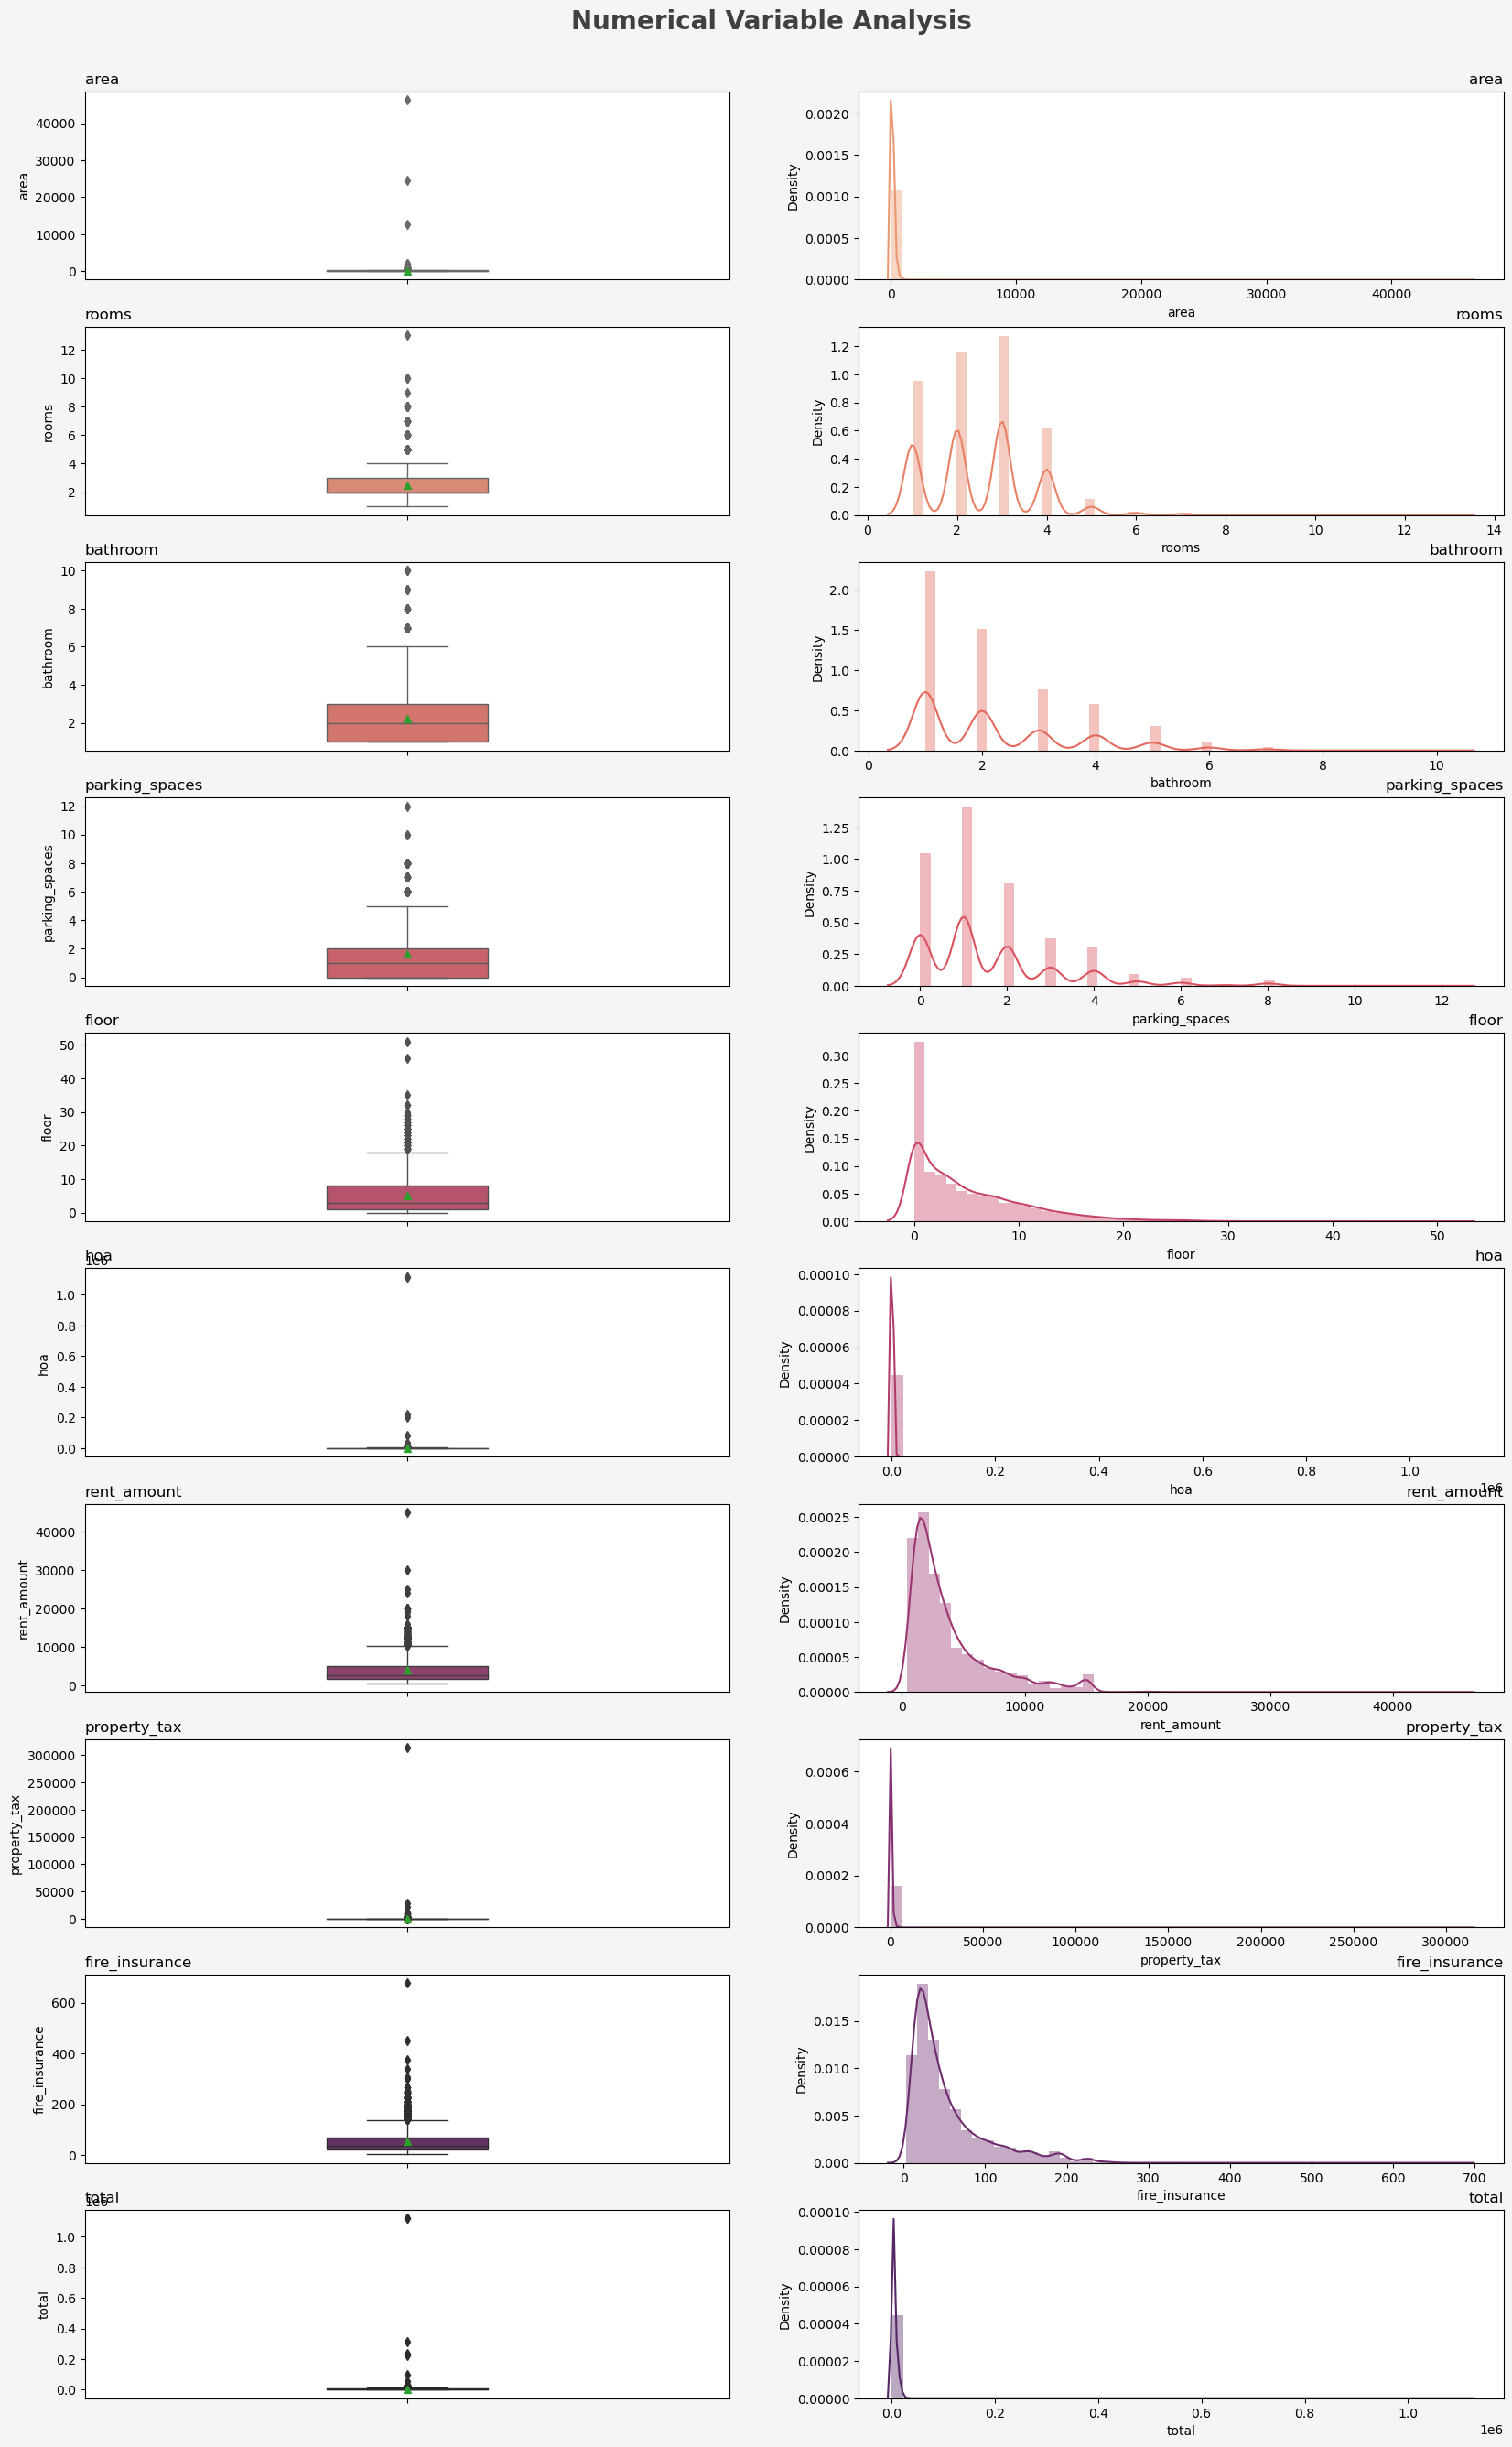

In [108]:
# size
figure, axis = plt.subplots(figsize = (20,30))

#Background
background = "#f5f5f5"
figure.set_facecolor(background)

#Color pallete
color_palette = sns.color_palette('flare', len(num_cols) * 2)

#Title
plt.suptitle("Numerical Variable Analysis", fontsize = 20, color = "#404040", fontweight = 600)

#Structure plot
lines = len(num_cols)
columns = 2
position = 1

for column in num_cols:

    #Boxplot
    plt.subplot(lines, columns, position)

    #Title
    plt.title(f'{column}', loc = 'left', fontsize = 12, fontweight = 200)

    #plot
    sns.boxplot(data = df2, y = column, showmeans = True, saturation = 0.75,
                linewidth=1, color = color_palette[position], width = 0.25)

    #change position
    position += 1

    #Distplot
    plt.subplot(lines, columns, position)

    #Title
    plt.title(f'{column}', loc = 'right', fontsize = 12, fontweight = 200)

    sns.distplot(df2[column], color = color_palette[position-1])

    #change position
    position += 1

#Adjust Grid
plt.subplots_adjust(top = .95, hspace = 0.25)

<AxesSubplot:ylabel='area'>

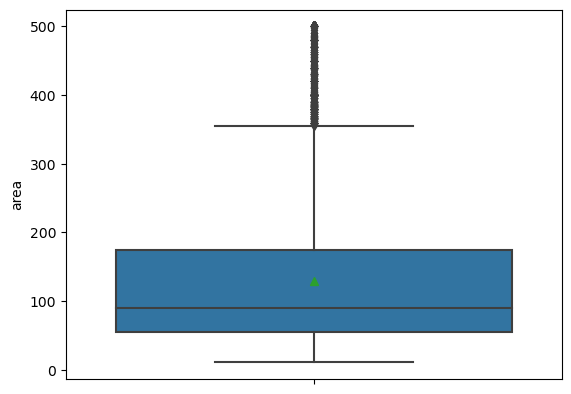

In [123]:
aux1 = df2[(df2['area']<= 500)]
sns.boxplot(data = aux1, y = 'area', showmeans = True)

In [128]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,area,11.0,46335.0,46324.0,149.217920,90.0,536.991829,69.596804,5548.308334
1,rooms,1.0,13.0,12.0,2.506079,2.0,1.171211,0.702391,1.487659
2,bathroom,1.0,10.0,9.0,2.236813,2.0,1.407132,1.213810,1.134852
3,parking_spaces,0.0,12.0,12.0,1.609147,1.0,1.589446,1.487534,2.769075
4,floor,0.0,51.0,51.0,5.042649,3.0,5.356925,1.435172,2.544460
5,hoa,0.0,1117000.0,1117000.0,1174.021698,560.0,15591.576074,69.039381,4912.249106
6,rent_amount,450.0,45000.0,44550.0,3896.247194,2661.0,3408.386117,1.838877,4.624228
7,property_tax,0.0,313700.0,313700.0,366.704358,125.0,3107.686983,96.013594,9667.782564
8,fire_insurance,3.0,677.0,674.0,53.300879,36.0,47.765797,1.970400,5.934963
9,total,499.0,1120000.0,1119501.0,5490.487000,3581.5,16483.955004,58.960803,3926.019305


In [129]:
df2.loc[df2['area'] == 46335]

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
2397,Belo Horizonte,46335,4,8,5,11,acept,furnished,960,8500,646,114,10220


# 3.0 Data Filtering

# 5.0 Data Preparation

# 6.0 Feature Selection

# 7.0 Machine Learning Modelling

# 8.0 Hyperparameter Fine Tuning

# 9.0 Translation and Interpretration Error